In [195]:


import math
import random
import numpy

import lsst.pex.config as pexConfig
import lsst.pipe.base as pipeBase
import lsst.daf.base as dafBase
import lsst.afw.geom as afwGeom
import lsst.afw.math as afwMath
import lsst.afw.table as afwTable
import lsst.meas.astrom as measAstrom
from lsst.pipe.tasks.registerImage import RegisterTask
from lsst.meas.algorithms import SourceDetectionTask, \
    starSelectorRegistry, PsfAttributes, SingleGaussianPsf
from lsst.ip.diffim import ImagePsfMatchTask, DipoleMeasurementTask, DipoleAnalysis, \
    SourceFlagChecker, KernelCandidateF, cast_KernelCandidateF, makeKernelBasisList, \
    KernelCandidateQa
#DiaCatalogSourceSelector, DiaCatalogSourceSelectorConfig
import lsst.ip.diffim.diffimTools as diffimTools
import lsst.ip.diffim.utils as diUtils
import lsst.afw.display.ds9 as ds9
import ImageSubtractionTools


In [203]:
import lsst.afw.image as afwImage
DATADIR="/renoir_data_02/jpreyes/lsst_data/data/CFHTLS_TEST"
scienceFolder = "subtract+0"
templateFolder = "coaddition"

SciencePath = DATADIR+"/output/coadd_r_dir/"+scienceFolder+"/deepCoadd/r/1/33,15.fits"
TemplatePath = DATADIR+"/output/coadd_r_dir/"+templateFolder+"/deepCoadd/r/1/33,15.fits"
#SciencePath = DATADIR+"/output/calexp/06AL01/D3/2006-05-24/r/calexp-849686-14.fits"
#TemplatePath = DATADIR+"/output/calexp/06AL01/D3/2006-05-24/r/calexp-849688-14.fits"


DATADIR="/renoir_data_02/jpreyes/lsst_data/data/CFHTLS_COMPLETE"
scienceFolder = "subtract+0"
templateFolder = "subtract+1"

SciencePath = DATADIR+"/output/coadd_r_dir/"+scienceFolder+"/deepCoadd/r/1/53,30.fits"
TemplatePath = DATADIR+"/output/coadd_r_dir/"+templateFolder+"/deepCoadd/r/1/53,30.fits"






scienceExp = afwImage.ExposureF(SciencePath)
templateExp = afwImage.ExposureF(TemplatePath)

scienceExp = ImageSubtractionTools.SubtractBackground(scienceExp)
templateExp = ImageSubtractionTools.SubtractBackground(templateExp)
self_schema = afwTable.SourceTable.makeMinimalSchema()
self_algMetadata = dafBase.PropertyList()

import lsst.ip.diffim as ipDiffim
config = ipDiffim.ImagePsfMatchTask.ConfigClass()
#Kernel name is Alard-Lupton by default
config.kernel.name = "AL"
subconfig = config.kernel.active
psfmatch = ipDiffim.ImagePsfMatchTask(config)

detection = SourceDetectionTask()
exposure = scienceExp
sciencePsf = exposure.getPsf()
templateExposure = templateExp
#templateSources = template.sources  ????
templateSources = psfmatch.getSelectSources(templateExposure)


# compute scienceSigmaOrig: sigma of PSF of science image before pre-convolution
ctr = afwGeom.Box2D(exposure.getBBox(afwImage.PARENT)).getCenter()
print ctr
psfAttr = PsfAttributes(sciencePsf, afwGeom.Point2I(ctr))
scienceSigmaOrig = psfAttr.computeGaussianWidth(psfAttr.ADAPTIVE_MOMENT)

# sigma of PSF of template image before warping
ctr = afwGeom.Box2D(templateExposure.getBBox(afwImage.PARENT)).getCenter()
psfAttr = PsfAttributes(templateExposure.getPsf(), afwGeom.Point2I(ctr))
templateSigma = psfAttr.computeGaussianWidth(psfAttr.ADAPTIVE_MOMENT)

# if requested, convolve the science exposure with its PSF
# (properly, this should be a cross-correlation, but our code does not yet support that)
# compute scienceSigmaPost: sigma of science exposure with pre-convolution, if done,
# else sigma of original science exposure

self_config_doPreConvolve = True
self_config_useGaussianForPreConvolution = False

if self_config_doPreConvolve:
    convControl = afwMath.ConvolutionControl()
    # cannot convolve in place, so make a new MI to receive convolved image
    srcMI = exposure.getMaskedImage()
    destMI = srcMI.Factory(srcMI.getDimensions())
    srcPsf = sciencePsf
    if self_config_useGaussianForPreConvolution:
        # convolve with a simplified PSF model: a double Gaussian
        kWidth, kHeight = sciencePsf.getLocalKernel().getDimensions()
        preConvPsf = SingleGaussianPsf(kWidth, kHeight, scienceSigmaOrig)
    else:
        # convolve with science exposure's PSF model
        preConvPsf = srcPsf
    afwMath.convolve(destMI, srcMI, preConvPsf.getLocalKernel(), convControl)
    exposure.setMaskedImage(destMI)
    scienceSigmaPost = scienceSigmaOrig * math.sqrt(2)
else:
    scienceSigmaPost = scienceSigmaOrig
#expId=18
#expBits = 64
#idFactory = afwTable.IdFactory.makeSource(expId, 64 - expBits)
self_doPreConvolve= True
selectSources = psfmatch.getSelectSources(exposure,
                        sigma = scienceSigmaPost,
                        doSmooth = not self_doPreConvolve,)
#                        idFactory = idFactory,)

FwhmPerSigma = 2 * math.sqrt(2 * math.log(2))
IqrToSigma = 0.741
nparam = len(makeKernelBasisList(psfmatch.config.kernel.active,
            referenceFwhmPix=scienceSigmaPost * FwhmPerSigma,
            targetFwhmPix=templateSigma * FwhmPerSigma))
import kernelCandidateQa as qa
kcQa = qa.KernelCandidateQa(nparam)
selectSources = kcQa.addToSchema(selectSources)
matches = afwTable.matchRaDec(templateSources, selectSources, 1.0*afwGeom.arcseconds,
                                                  False)

import diaCatalogSourceSelectorv92 as diaCSS
#sourceSelector = starSelectorRegistry.makeField("Source selection algorithm", default="diacatalog")
#sourceSelector = sourceSelector.diacatalog
#hasattr(sourceSelector, 'selectStars')
sourceSelector = diaCSS.DiaCatalogSourceSelector()


kernelSources = sourceSelector.selectSources(exposure, selectSources, matches=matches)


controlStepSize = 5
random.shuffle(kernelSources, random.random)
controlSources = kernelSources[::controlStepSize]
kernelSources = [k for i,k in enumerate(kernelSources) if i % controlStepSize]


#wcsResults = self.fitAstrometry(templateSources, templateExposure, selectSources)
#register = RegisterTask(name="reg")
#wcsResults = register.run(templateSources, templateExposure.getWcs(),
#                                    templateExposure.getBBox(), selectSources)

#warpedExp = register.warpExposure(templateExposure, wcsResults.wcs,
#                                            exposure.getWcs(), exposure.getBBox())
#templateExposure2 = warpedExp
convolveTemplate = False
doUseRegister = False
subtractRes = psfmatch.subtractExposures(
                templateExposure=templateExposure,
                scienceExposure=exposure,
                candidateList=kernelSources,
                convolveTemplate=convolveTemplate,
                doWarping=not doUseRegister
            )
subtractedExposure = subtractRes.subtractedExposure
ds9.setMaskTransparency(100)
ds9.mtv(subtractedExposure)

(42800, 24400)


In [204]:
config_doPreConvolve = True
# Erase existing detection mask planes
mask  = subtractedExposure.getMaskedImage().getMask()
mask &= ~(mask.getPlaneBitMask("DETECTED") | mask.getPlaneBitMask("DETECTED_NEGATIVE"))

table = afwTable.SourceTable.make(self_schema)
table.setMetadata(self_algMetadata)
results = detection.makeSourceCatalog(
    table=table,
    exposure=subtractedExposure,
    doSmooth=not config_doPreConvolve
)

diaSources = results.sources

print len(diaSources)

239


This is the method that merge all footprints too near each other. Different grow_values change the outcome

In [205]:
grow_value_x = 5
grow_value_y = 5


fpSet = results.fpSets.positive
fpSet.merge(results.fpSets.positive,grow_value_x ,grow_value_y, False)
diaSources = afwTable.SourceCatalog(table)
fpSet.makeSources(diaSources)
print len(diaSources)

19


In [382]:
from  lsst.meas.algorithms import SourceMeasurementTask, SourceDetectionTask

#import lsst.meas.algorithms. as sourceDetector
schema = afwTable.SourceTable.makeMinimalSchema()
sdTask = SourceDetectionTask()
sdTask.__init__(schema=schema)


#table = afwTable.SourceTable.make(afwTable.SourceTable.makeMinimalSchema())
#table = afwTable.SourceTable.make(detectedSources.schema)
#table.setMetadata(algMetadata)
sdTask.run( table = diaSources.getTable(), exposure=subtractedExposure, doSmooth=False)



#results = sdTask.makeSourceCatalog(table=table, exposure=subtractedExposure, doSmooth=not True)

#detectedSources= results.sources


ValueError: Table has incorrect Schema

In [330]:
ds9.mtv(subtractedExposure, frame=1)
ds9.ds9Cmd("zoom to fit")
ds9.setMaskTransparency(100)
with ds9.Buffering():
    for source in diaSources:
        xs = source.getFootprint().getCentroid().getX()-subtractedExposure.getX0()
        ys = source.getFootprint().getCentroid().getY()-subtractedExposure.getY0()
        ds9.dot('+', xs, ys, frame=1,size=10, ctype = ds9.RED)

In [206]:
kernelCandList = []
for cell in subtractRes.kernelCellSet.getCellList():
    for cand in cell.begin(False): # include bad candidates
        kernelCandList.append(cast_KernelCandidateF(cand))

basisList = afwMath.cast_LinearCombinationKernel(
kernelCandList[0].getKernel(KernelCandidateF.ORIG)).getKernelList()



class myTaskConfig(pexConfig.Config):
    s=1
class myTask(pipeBase.CmdLineTask):
    _DefaultName = "hop"
    ConfigClass = myTaskConfig
    def __init__(self, **kwargs):
        pipeBase.CmdLineTask.__init__(self, **kwargs)    
    def run(self):
        self.hop=None
        
d=myTask()


config_subtract = config
controlCandList = \
                    diffimTools.sourceTableToCandidateList(controlSources, 
                                                           subtractRes.warpedExposure, exposure,
                                                           config_subtract.kernel.active,
                                                           config_subtract.kernel.active.detectionConfig,
                                                           d.log, doBuild=True, basisList=basisList)


In [207]:
from lsst.ip.diffim import diffimLib

for kernelCandidate in kernelCandList:
     if kernelCandidate.getStatus() != afwMath.SpatialCellCandidate.UNKNOWN:

         kType = getattr(diffimLib.KernelCandidateF, "ORIG")
         di = kernelCandidate.getDifferenceImage(kType)
         mask = di.getMask()
         mask.addMaskPlane("NO_DATA")

In [208]:
kcQa.apply(kernelCandList, subtractRes.psfMatchingKernel, subtractRes.backgroundModel,
                                dof=nparam)
kcQa.apply(controlCandList, subtractRes.psfMatchingKernel, subtractRes.backgroundModel)

LengthError: 
  File "include/lsst/afw/table/FieldBase.h", line 343, in void lsst::afw::table::FieldBase<lsst::afw::table::Array<U> >::setValue(U*, const ndarray::Manager::Ptr&, const ndarray::ExpressionBase<Other>&) const [with Derived = ndarray::Array<const double, 1, 0>, U = double]
    Incorrect size in array field assignment. {0}
lsst::pex::exceptions::LengthError: 'Incorrect size in array field assignment.'


(array([ 35.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  2.17362456e-02,   7.37112741e+00,   1.47205186e+01,
         2.20699097e+01,   2.94193009e+01,   3.67686921e+01,
         4.41180832e+01,   5.14674744e+01,   5.88168656e+01,
         6.61662567e+01,   7.35156479e+01]),
 <a list of 10 Patch objects>)

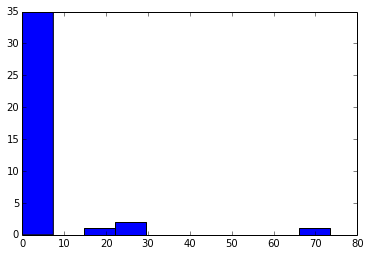

In [202]:
%matplotlib inline
import matplotlib.pyplot as plt
kc1 =[]
for k in kernelCandList:
    kc = k.getSource()['KCDiffimMseResids_LOCAL']
    if not math.isnan(kc):
        kc1.append(kc)
kc1    
plt.hist(kc1)

(array([ 26.,   5.,   2.,   1.,   1.,   1.,   2.,   0.,   0.,   1.]),
 array([ 0.15164594,  0.76674978,  1.38185362,  1.99695745,  2.61206129,
        3.22716513,  3.84226896,  4.4573728 ,  5.07247663,  5.68758047,
        6.30268431]),
 <a list of 10 Patch objects>)

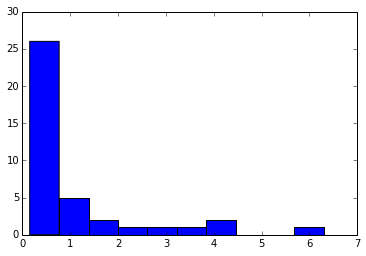

In [335]:
%matplotlib inline
import matplotlib.pyplot as plt
kc1 =[]
for k in kernelCandList:
    kc = k.getSource()['KCDiffimStDev_LOCAL']
    if not math.isnan(kc):
        kc1.append(kc)
kc1    
plt.hist(kc1)

(array([ 33.,   2.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([  2.65099462e-02,   5.09342453e+00,   1.01603391e+01,
         1.52272537e+01,   2.02941683e+01,   2.53610829e+01,
         3.04279975e+01,   3.54949121e+01,   4.05618266e+01,
         4.56287412e+01,   5.06956558e+01]),
 <a list of 10 Patch objects>)

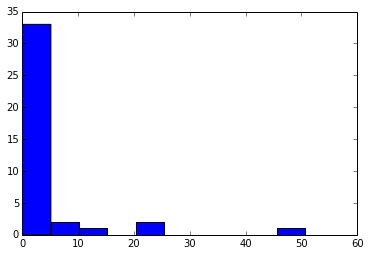

In [336]:
%matplotlib inline
import matplotlib.pyplot as plt
kc1 =[]
for k in kernelCandList:
    kc = k.getSource()['KCDiffimChiSq_LOCAL']
    if not math.isnan(kc):
        kc1.append(kc)
kc1    
plt.hist(kc1)

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Coord'](name="coord", doc="position in ra/dec", units="IRCS; radians"), Key<Coord>(offset=8, nElements=2)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="flags.negative", doc="set if source was detected as significantly negative"), Key['Flag'](offset=32, bit=0)),
    (Field['Flag'](name="flags.badcentroid", doc="the centroid algorithm used to feed centers to other algorithms failed"), Key['Flag'](offset=32, bit=1)),
    (Field['PointD'](name="centroid.sdss", doc="SDSS-algorithm centroid measurement", units="pixels"), Key<PointD>(offset=40, nElements=2)),
    (Field['CovPointF'](name="centroid.sdss.err", doc="covariance matrix for centroid.sdss", units="pixels^2"), Key<CovPointF>(offset=56, nElements=3)),
    (Field['Flag'](name="centroid.sdss.flags", doc="set if the centroid.sdss measurement did not fully succeed"

In [94]:
import lsst.afw.display.utils as displayUtils
import numpy as np
diaSourcesList = []
mos = displayUtils.Mosaic()

for source  in  diaSources:
    diaSourcesList.append(source)
    bbox = source.getFootprint().getBBox()
    Begin = afwGeom.Point2I(bbox.getBeginX(), bbox.getBeginY())

    End = afwGeom.Point2I(bbox.getEndX(), bbox.getEndY())

    ExpOrig = afwGeom.Point2I(subtractedExposure.getX0()-1, subtractedExposure.getY0()-1)
 
    correctedBegin = bbox.getBegin()- ExpOrig
    correctedEnd = bbox.getEnd() - ExpOrig

    correctedBegin= afwGeom.Point2I(correctedBegin.getX()-20,correctedBegin.getY()-20 )
    correctedEnd = afwGeom.Point2I(correctedEnd.getX()+20,correctedEnd.getY()+20 )
    
    
    
    bboxT = afwGeom.Box2I(correctedBegin,correctedEnd)
    
    #print bboxT.toString

    stamp = exposure.Factory(subtractedExposure,bboxT, True)
    stamp2 = exposure.Factory(scienceExp,bboxT, True)
    
    var = subtractedExposure.getMaskedImage().getVariance()
    var = var.Factory(var, True)
    np.sqrt(var.getArray(), var.getArray())
       
       
        
    sub_exp = subtractedExposure.getMaskedImage().getImage()
    sub_exp = sub_exp.Factory(sub_exp, True)
    
    sc_exp = scienceExp.getMaskedImage().getImage()
    sc_exp = sc_exp.Factory(sc_exp, True)
    
    MinValSub= np.inf
    MaxValSub= -np.inf
    MinValSc= np.inf
    MaxValSc= -np.inf
    SumSub = 0
    SumSc = 0
    
    for i in range(0,sc_exp.getHeight()):
        for j in range(0, sc_exp.getWidth()):
                if (MinValSc > sc_exp.get(i,j)):
                    MinValSc = sc_exp.get(i,j)
                if (MaxValSc < sc_exp.get(i,j)):
                    MaxValSc = sc_exp.get(i,j)
                if (MinValSub > sub_exp.get(i,j)):
                    MinValSub = sub_exp.get(i,j)
                if (MaxValSub < sub_exp.get(i,j)):
                    MaxValSub = sub_exp.get(i,j)
                    
                SumSub += sc_exp.get(i,j)
                SumSc += sub_exp.get(i,j)
                
    total = sc_exp.getHeight()*sc_exp.getWidth()

                    
    ScRange = MaxValSc - MinValSc
    SubRange = MaxValSub - MinValSub
   
    for i in range(0,sub_exp.getHeight()):
        for j in range(0, sub_exp.getWidth()):
            sub_exp.set(i,j, sub_exp.get(i,j)-MinValSub) 

    stamp = sub_exp.Factory(sub_exp, bboxT, True)
    
    
    var = scienceExp.getMaskedImage().getVariance()
    var = var.Factory(var, True)
    np.sqrt(var.getArray(), var.getArray())
       
       
        
 
       
    stamp2 = sc_exp.Factory(sc_exp, bboxT, True)
    
    im = displayUtils.Mosaic(gutter=0, background=0, mode="x")
    
    im.append(stamp)
   # im.append(stamp)
   # im.append(stamp2.getMaskedImage().getImage())
    im.append(stamp2)
    mos.append(im.makeMosaic())



mosaicImage = mos.makeMosaic(frame=1, title="mosaic")

#ds9.setMaskTransparency(100)
#ds9.mtv(mosaicImage)
#ds9.mtv(subtractedExposure, frame=2)

In [94]:
.mos2 = displayUtils.Mosaic()
mos2.append(mosaicImage)
mos2.append(mosaicImage)
mosaicImage2 = mos2.makeMosaic(frame=1, title="mosaic")

ds9.mtv(mosaicImage2)


In [372]:
ds9.mtv(subtractedExposure, frame=1)
ds9.ds9Cmd("zoom to fit")
ds9.setMaskTransparency(100)
with ds9.Buffering():
    for source in diaSources:
        xs = source.getFootprint().getCentroid().getX()-subtractedExposure.getX0()
        ys = source.getFootprint().getCentroid().getY()-subtractedExposure.getY0()
        ds9.dot('+', xs, ys, frame=1,size=10, ctype = ds9.RED)

#ImageViewer.saveRemoteImage("subtractedExp.png")

In [83]:
subtractedExposure.Factory

<bound method ExposureF.Factory of <lsst.afw.image.imageLib.ExposureF; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::image::Exposure< float,lsst::afw::image::MaskPixel,lsst::afw::image::VariancePixel > > *' at 0x4bf4b70> >>

In [340]:
import  lsst.ip.diffim.dipoleMeasurement as dipoleMeasurer

dipTask = dipoleMeasurer.DipoleMeasurementTask
minSchema = afwTable.SourceTable.makeMinimalSchema()
dipTask = dipTask(minSchema)

dipConfig = dipTask.ConfigClass()

minSchema.addField(dipTask._ClassificationFlag, "F")


dipTask.run(subtractedExposure, diaSources)


NotFoundError: 
  File "src/table/Schema.cc", line 233, in lsst::afw::table::SchemaItem<T> lsst::afw::table::detail::SchemaImpl::find(const std::string&) const [with T = lsst::afw::table::Point<double>]
    Field or subfield withname 'centroid.sdss' not found with type 'PointD'. {0}
lsst::pex::exceptions::NotFoundError: 'Field or subfield withname 'centroid.sdss' not found with type 'PointD'.'


classification.dipole
